In [1]:
%matplotlib inline
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100

In [28]:
from collections import Counter

import os
import time
import tqdm
import corner
import numpy as np
import pandas as pd
from functools import partial
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp, gaussian_kde
from sklearn.decomposition import PCA

In [11]:
from exoabc import Simulator, data

In [13]:
period_range = (50, 300)
prad_range = (0.75, 2.5)
depth_range = (0, 1000)
maxn = 5

In [15]:
prefix = "q1_q16"
stlr = data.get_burke_gk(prefix=prefix).iloc[:5000]
kois = data.get_candidates(stlr=stlr, prefix=prefix)

In [16]:
sim = Simulator(
    stlr,
    period_range[0], period_range[1], 0.0,
    prad_range[0], prad_range[1], -2.0,
    -3.0, np.zeros(maxn),
    min_period_slope=-5.0, max_period_slope=3.0,
    min_radius_slope=-5.0, max_radius_slope=3.0,
    min_log_sigma=-5.0, max_log_sigma=np.log(np.radians(90)),
    min_log_multi=-5.0, max_log_multi=3.0,
    release=prefix,
    seed=int(os.getpid() + 1000*time.time()) % 20000,
)

In [22]:
def compute_stats(catalog):
    m = (period_range[0] <= catalog.koi_period) & (catalog.koi_period <= period_range[1])
    m &= (prad_range[0] <= catalog.koi_prad) & (catalog.koi_prad <= prad_range[1])
    m &= (depth_range[0] <= catalog.koi_depth) & (catalog.koi_depth <= depth_range[1])
    c = catalog[m]
    
    # Multiplicity
    h = Counter(Counter(c.kepid).values())
    hist = np.zeros(maxn+1, dtype=int)
    for i in range(1, maxn+1):
        hist[i] = h.get(i, 0)
    hist[0] = len(stlr) - np.sum(hist[1:])
    
    return hist, np.array(c.koi_period), np.array(c.koi_depth), np.array(c.koi_duration)

def compute_distance(ds1, ds2):
    norm = max(np.max(ds1[0]), np.max(ds2[0]))
    multi_dist = np.sum((np.log(ds1[0]+1) - np.log(ds2[0]+1))**2.0)
    period_dist = ks_2samp(ds1[1], ds2[1]).statistic
    depth_dist = ks_2samp(ds1[2], ds2[2]).statistic
    
    return multi_dist + period_dist + depth_dist

In [23]:
obs_stats = compute_stats(kois)

In [24]:
obs_stats

(array([4995,    5,    0,    0,    0,    0]),
 array([ 105.0141157,  180.92477  ,   54.2812031,   88.0712696,   54.4092333]),
 array([ 287.3,  696.1,  155. ,  955. ,  230.3]),
 array([ 6.287,  8.552,  5.317,  6.772,  9.511]))

In [47]:
def sample(initial=None):
    if initial is None:
        lp = sim.sample_parameters()
        if not np.isfinite(lp):
            return np.inf, sim.get_parameters(), sim.state
    else:
        lp = sim.set_parameters(initial)
        if not np.isfinite(lp):
            return np.inf, sim.get_parameters(), sim.state

    pars, state = sim.get_parameters(), sim.state
    df = sim.sample_population()
    if len(df) <= 1:
        return np.inf, pars, state
    return compute_distance(obs_stats, compute_stats(df)), pars, state

In [97]:
n = 5000
initial_distances, inital_theta, _ = map(np.array, zip(*[sample() for _ in tqdm.tqdm(range(n), total=n)]))

In [99]:
m = np.isfinite(initial_distances)

In [104]:
q = np.percentile(initial_distances[m], 10)
print(q)

0.983241190128


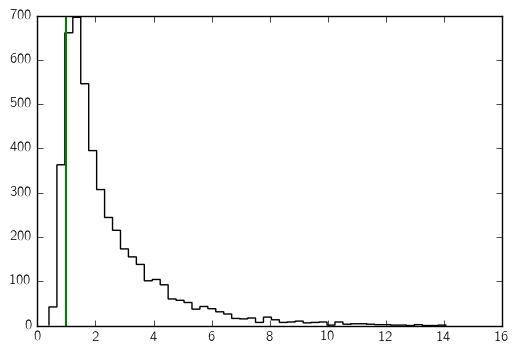

In [105]:
plt.hist(initial_distances[m], 50, color="k", histtype="step")
plt.gca().axvline(q, color="g", lw=1.5);

In [106]:
def mh(log_p_func, theta0, niter, sigma=(1e-6, 1e-1)):
    ndim = len(theta0)
    theta = np.array(theta0)
    chain = np.empty((niter, ndim))
    lp = log_p_func(theta0)
    acc = 0
    for i in tqdm.tqdm(range(niter), total=niter):
        q = np.array(theta)
        ind = np.random.randint(ndim)
        q[ind] += np.exp(np.random.uniform(*(np.log(sigma)))) * np.random.randn()
        lq = log_p_func(q)

        u = np.log(np.random.rand())
        if u < lq - lp:
            theta = q
            lp = lq
            acc += 1
        
        chain[i] = theta

    return chain, acc / niter

In [107]:
def pseudo_likelihood(S, eps, params):
    dist = np.array([sample(params)[0] for _ in range(S)])
    return np.logaddexp.reduce(-0.5 * (dist / eps)**2)

In [109]:
pseudo_likelihood_func = partial(pseudo_likelihood, 5, q)

In [ ]:
p0 = inital_theta[np.argmin(initial_distances)]
samples, acc = mh(pseudo_likelihood_func, p0, 10000, sigma=(1e-3, 1.0))
print(acc)

  1%|          | 100/10000 [00:06<10:15, 16.09it/s]

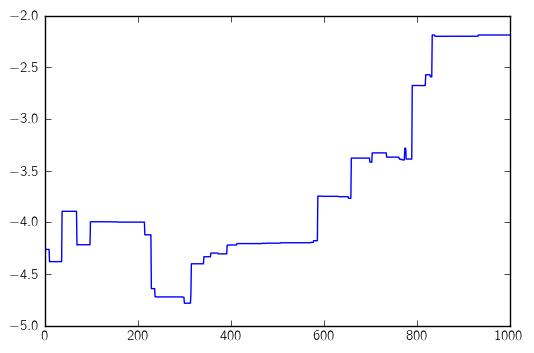

In [115]:
plt.plot(samples[:, 4])

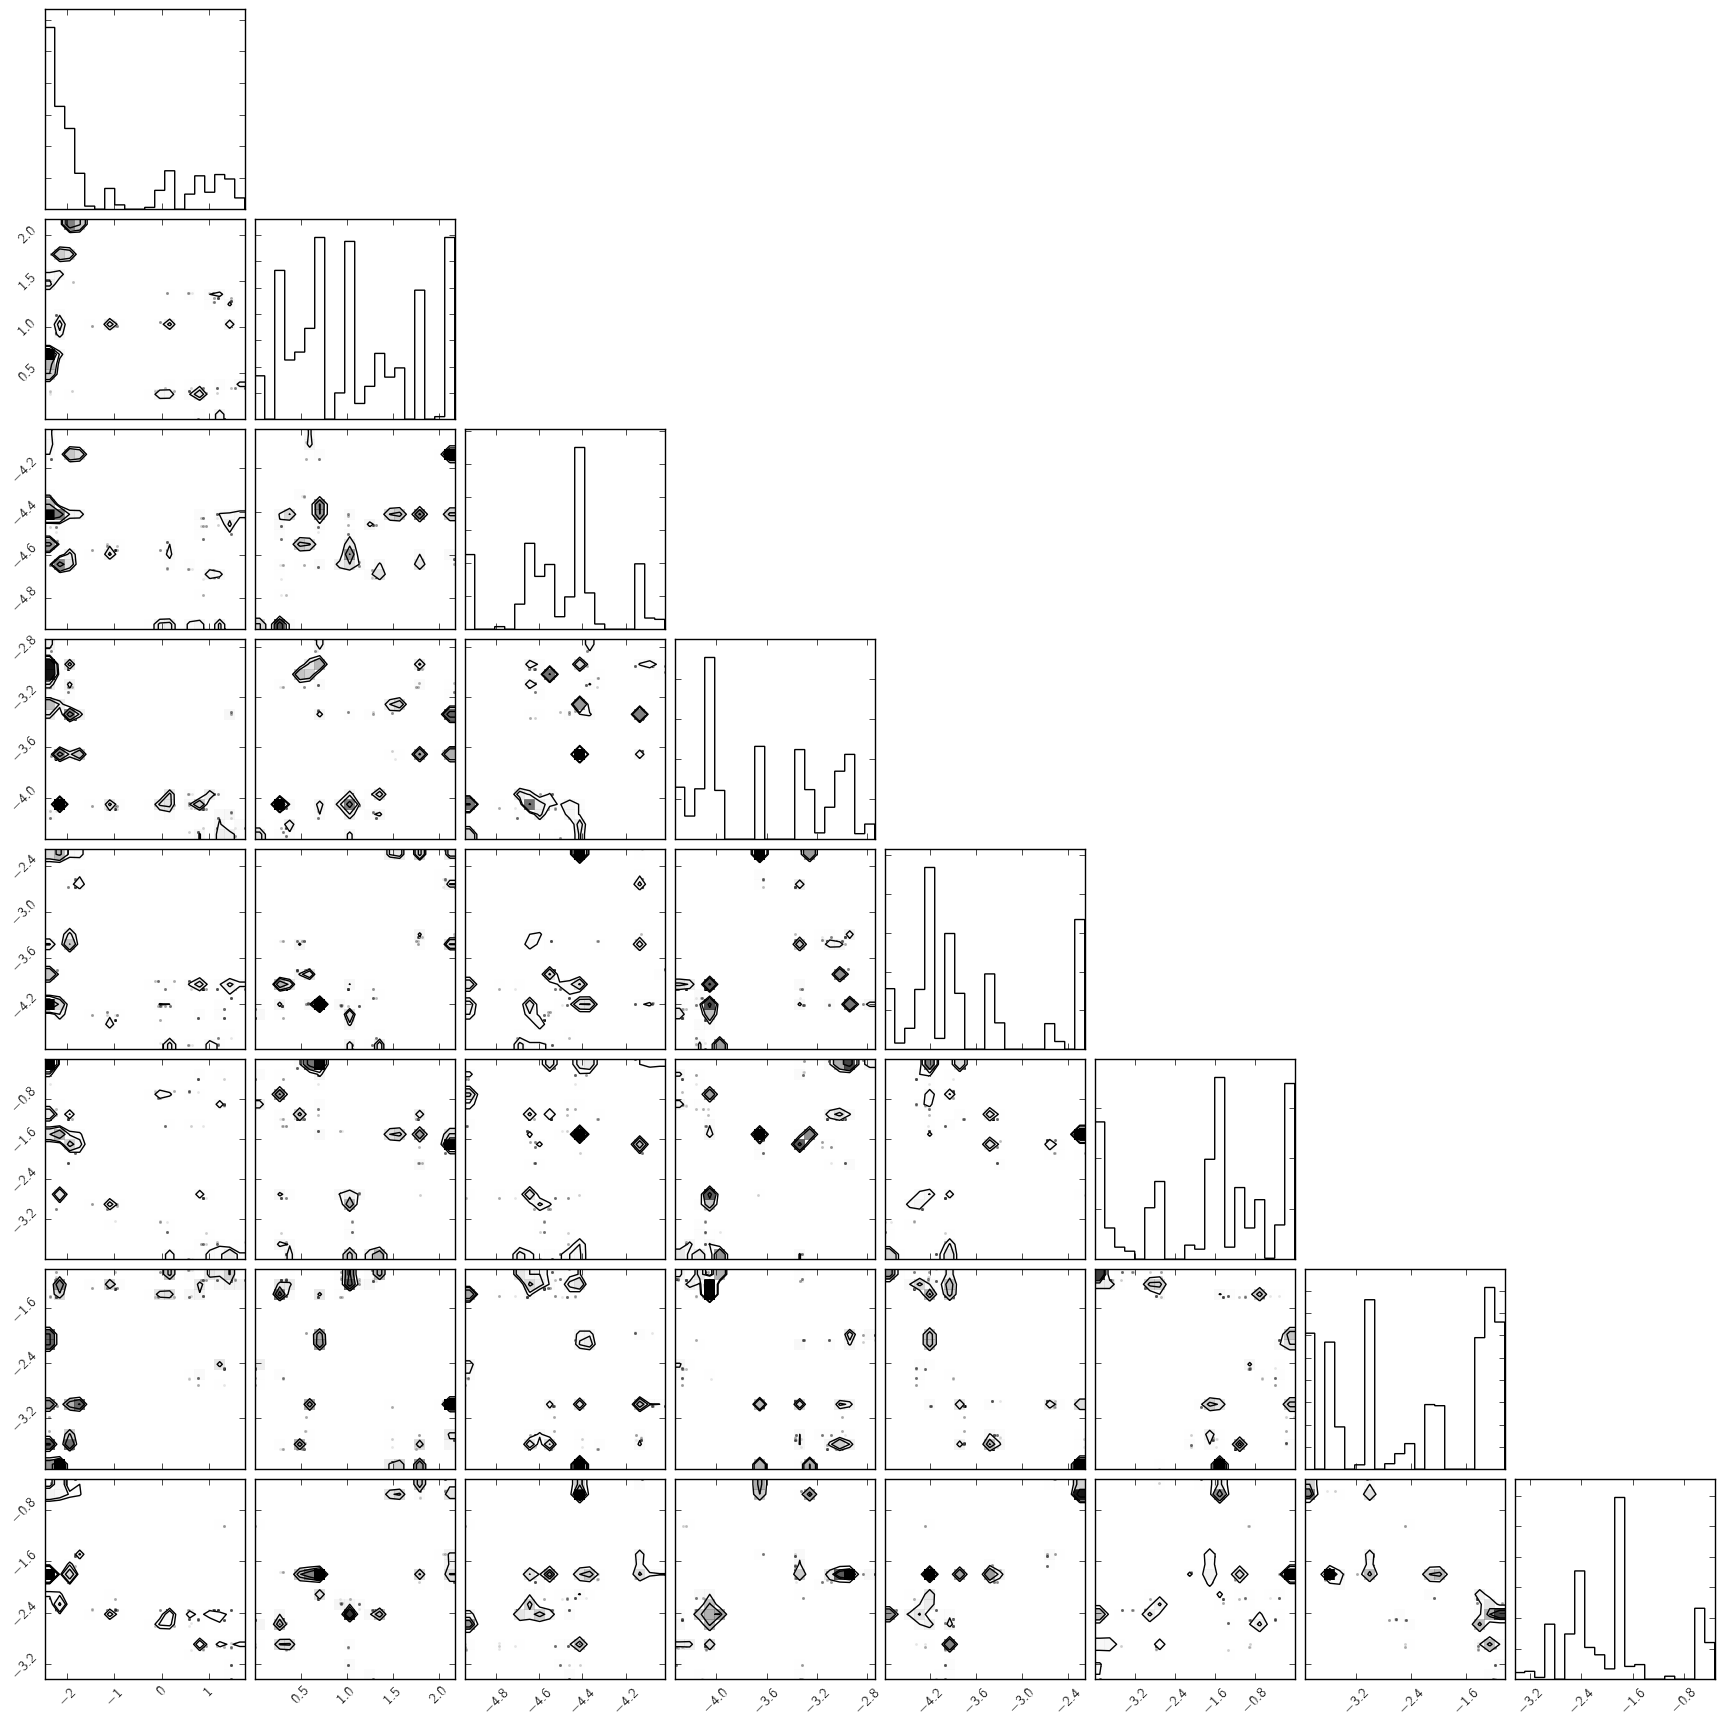

In [116]:
corner.corner(samples);

In [343]:
n = 10
samples = [sample() for _ in tqdm.tqdm(range(n), total=n)]

In [344]:
samples

[((5.4165319507509428, 0.33301670488044549, 0.14693743858499836),
  array([-2.68672637,  1.36058009, -2.12645659, -7.43848629,  4.37005485]),
  b'2874933442 2015980857 1674764450 306543789 1251343460 1074267216 1108467715 1834239306 2404554191 1405780039 422688259 2374837923 721242642 1776171731 525990296 2660649060 1872800491 3426354372 891720759 1660552100 427391983 3161964568 2136141846 1351920199 1976175101 2005805193 4198868785 4268241523 1182251549 966973663 40289898 1362013510 31824690 146285273 1885476611 3330072568 2329946635 2805253744 3226689677 2896297705 3920789448 874813020 2993013263 2297509008 2211530002 2999299152 1005090673 2068699049 3558632518 3734536061 2290872228 465201368 3279241822 2099858825 2990944056 2776016342 2461177302 3593012495 4072416016 2887645247 490139637 2649069074 2030342066 916803109 4179309806 4180783926 2948006910 2017551920 1868572018 772183313 3450720183 1760212043 1935276135 4089631534 1175803924 3883012658 2215198563 1002626505 3197061868 20

In [345]:
distances = np.array([s[0] for s in samples])
m = np.all(np.isfinite(distances), axis=1)
distances = distances[m]
params = np.array([s[1] for s in samples])[m]
states = np.array([s[2] for s in samples])[m]

In [346]:
print(distances)

[[  5.41653195e+00   3.33016705e-01   1.46937439e-01]
 [  8.30977942e-01   4.62319371e-01   2.42271813e-01]
 [  1.39912809e-01   3.55418224e-01   4.38200632e-01]
 [  9.32163562e-01   1.85659411e-01   1.14047924e-01]
 [  1.89095906e-03   1.76056338e-01   2.08989229e-01]
 [  2.98148304e+00   1.65492958e-01   3.54124748e-01]
 [  8.97708179e-01   1.16880387e-01   1.01744797e-01]
 [  1.92650707e+00   5.64067331e-01   2.63998626e-01]
 [  2.58949119e+00   2.86971831e-01   1.79137324e-01]
 [  1.35622495e+00   5.79029734e-01   1.78403756e-01]]


In [347]:
model = PCA(1)
model.fit(distances)

PCA(copy=True, n_components=1, whiten=False)

In [348]:
model.components_

array([[-0.99991874, -0.00504018,  0.01170952]])

In [349]:
w = np.abs(model.components_[0])
w /= np.sum(w)
scalar = np.dot(distances, w)

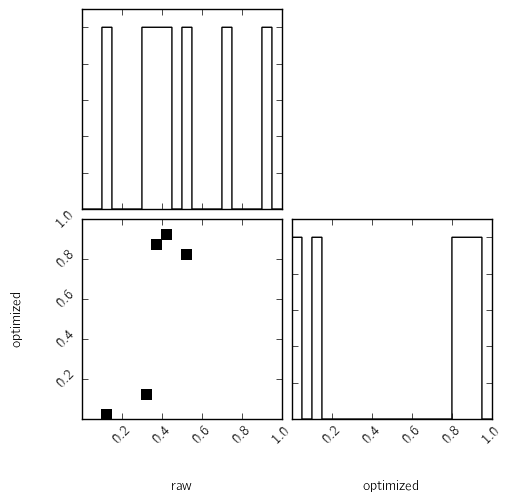

In [350]:
points = np.vstack([np.sum(distances, axis=1) / 3.0, scalar]).T
corner.corner(points, range=[(0, 1), (0, 1)], labels=["raw", "optimized"]);

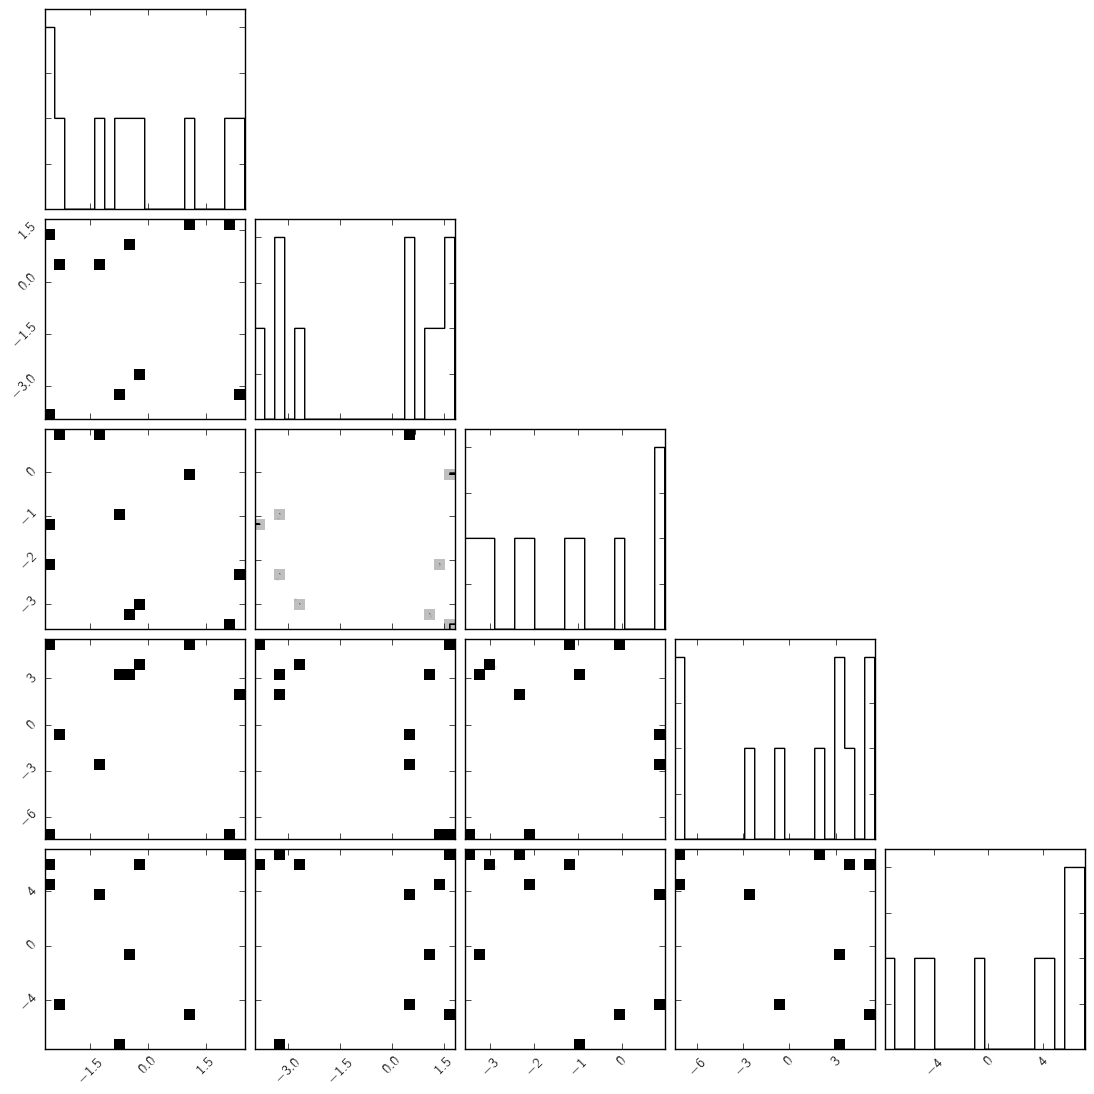

In [351]:
inds = np.argsort(scalar)
corner.corner(params[inds[:500]]);

In [386]:
i = 1
# p = np.array(new_params[new_inds[i]])
p = np.array([-0.7357879, -1.11290583, 0.19843469, 6.54973016, 11.39524634])
print(p)

sim.set_parameters(p)
# sim.state = new_states[new_inds[i]]
pop = sim.sample_population()
sim_stats = compute_stats(pop)
sim_stats[0], obs_stats[0]

[ -0.7357879   -1.11290583   0.19843469   6.54973016  11.39524634]


(array([93674,   185,     0]), array([93718,   140,     1]))

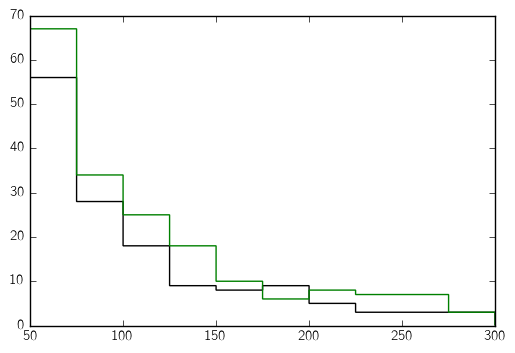

In [387]:
plt.hist(obs_stats[1], range=period_range, histtype="step", color="k")
plt.hist(sim_stats[1], range=period_range, histtype="step", color="g");

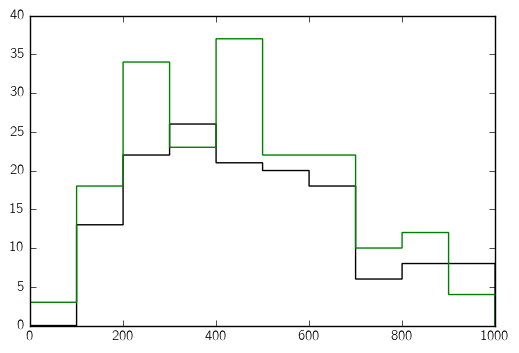

In [388]:
plt.hist(obs_stats[2], range=depth_range, histtype="step", color="k")
plt.hist(sim_stats[2], range=depth_range, histtype="step", color="g");

In [178]:
kde = gaussian_kde(new_params[new_inds].T)
#kde.factor *= 2

In [179]:
new_n = 50000
new_x = kde.resample(new_n)
new_logpdfs = kde.logpdf(new_x)

In [180]:
new_samples = [sample(x) for x in tqdm.tqdm(new_x.T, total=new_n)]

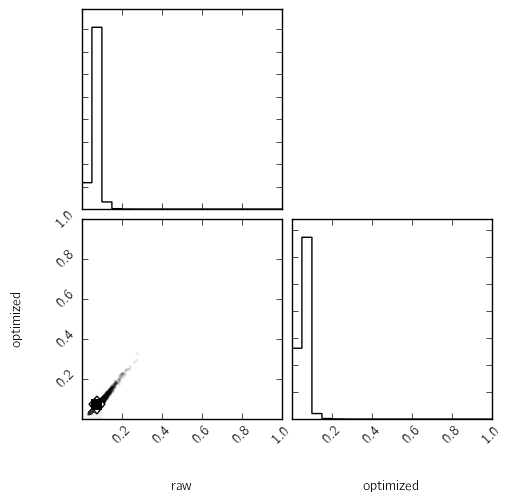

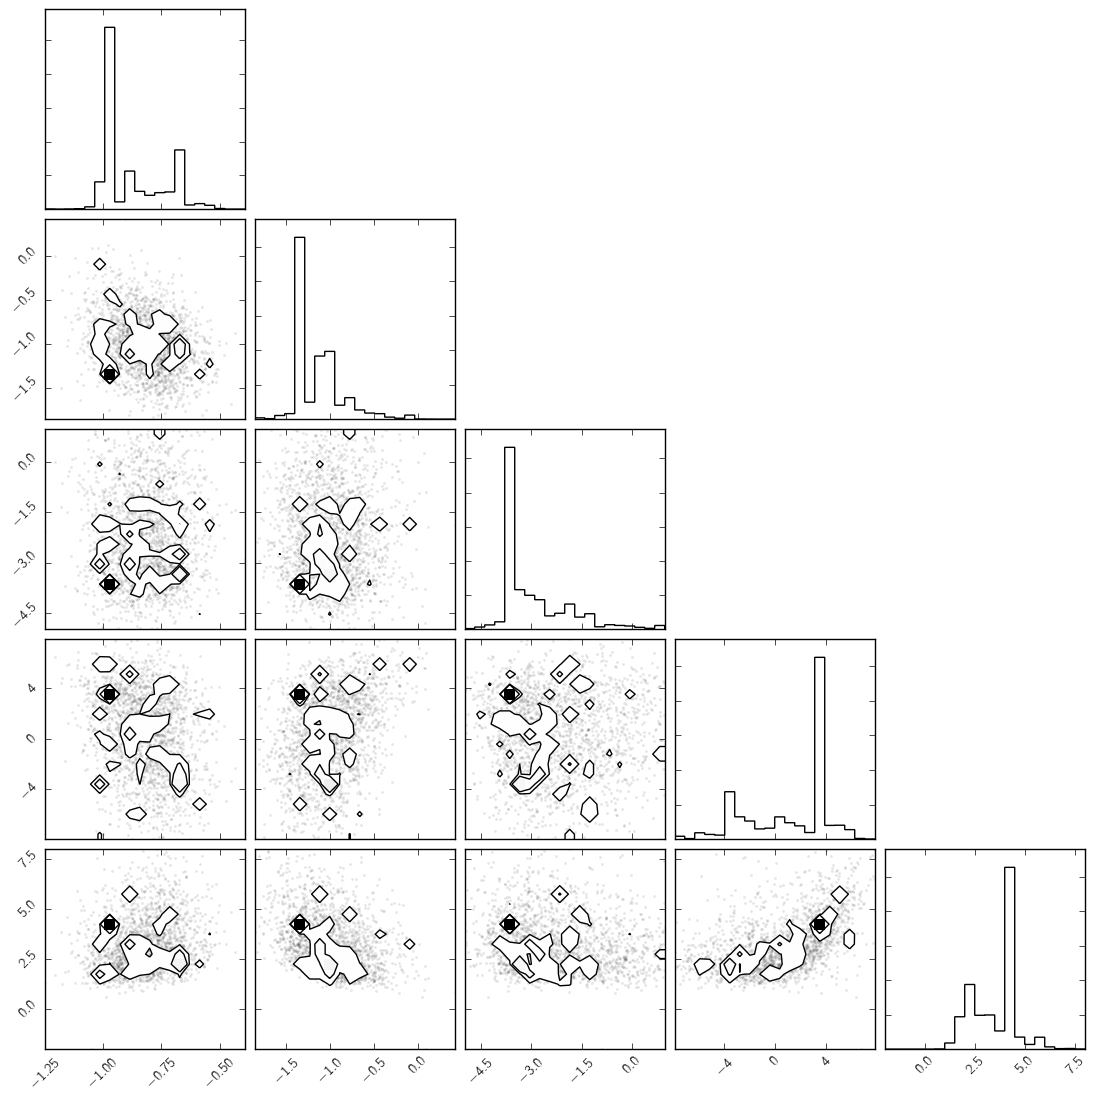

In [190]:
new_distances = np.array([s[0] for s in new_samples])
m = np.all(np.isfinite(new_distances), axis=1)
new_distances = new_distances[m]
new_params = np.array([s[1] for s in new_samples])[m]
new_states = np.array([s[2] for s in new_samples])[m]

new_model = PCA(1)
new_model.fit(new_distances)

new_w = np.abs(new_model.components_[0])
new_w /= np.sum(new_w)
new_scalar = np.dot(new_distances, new_w)

points = np.vstack([np.sum(new_distances, axis=1) / 3.0, new_scalar]).T
corner.corner(points, range=[(0, 1), (0, 1)], labels=["raw", "optimized"]);

new_inds = np.argsort(new_scalar)[:2000]
weights = new_logpdfs[new_inds]
weights = np.exp(np.min(weights) - weights)
# weights = None
corner.corner(new_params[new_inds], weights=weights);

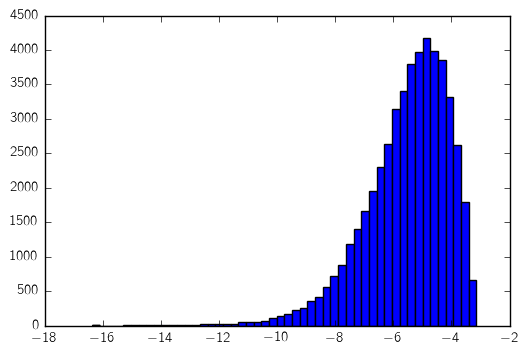

In [191]:
plt.hist(new_logpdfs, 50); # - np.max(new_logpdfs)

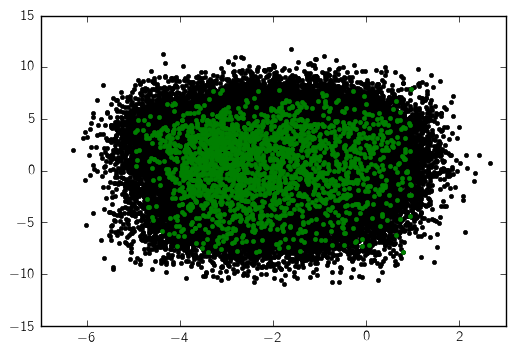

In [192]:
plt.plot(new_x[2], new_x[3], ".k")
x = new_params[new_inds]
plt.plot(x[:, 2], x[:, 3], ".g")

In [205]:
new_model = PCA(1)
new_model.fit(new_distances)
w = np.abs(new_model.components_[0])
print(w / np.sum(w))

_, ev = np.linalg.eig(np.cov(new_distances, rowvar=False))
w = np.abs(ev[:, 0])
print(w / np.sum(w))

[ 0.43127316  0.33720027  0.23152658]
[ 0.43127316  0.33720027  0.23152658]


In [206]:
np.linalg.svd(np.cov(new_distances, rowvar=False))

(array([[-0.72556691,  0.60172501,  0.33388572],
        [-0.56730022, -0.24838756, -0.78515864],
        [-0.38951653, -0.75909857,  0.52158052]]),
 array([ 0.00082769,  0.00074678,  0.00073729]),
 array([[-0.72556691, -0.56730022, -0.38951653],
        [ 0.60172501, -0.24838756, -0.75909857],
        [ 0.33388572, -0.78515864,  0.52158052]]))

In [207]:
ev

array([[ 0.72556691,  0.60172501,  0.33388572],
       [ 0.56730022, -0.24838756, -0.78515864],
       [ 0.38951653, -0.75909857,  0.52158052]])

In [216]:
def fit_distances(distances):
    _, ev = np.linalg.eig(np.cov(distances, rowvar=False))
    w = np.abs(ev[:, 0])
    w /= np.sum(w)
    print(w)
    return np.dot(distances, w)

In [217]:
fit_distances(new_distances).max()

[ 0.43127316  0.33720027  0.23152658]


0.32805194637736179

In [222]:
# iteration 1
N = 1000
theta = list(map(sample, tqdm.tqdm((None for _ in range(N)), total=N)))
distances = np.array([s[0] for s in samples])
m = np.all(np.isfinite(distances), axis=1)
distances = distances[m]
params = np.array([s[1] for s in samples])[m]
states = np.array([s[2] for s in samples])[m]
rho = np.sum(distances, axis=1)

In [223]:
rho

array([ 1.41399497,  0.64084507,  0.7839419 , ...,  0.32291759,
        0.59231125,  0.48901635])

In [252]:
tau = np.sqrt(2*np.var(params, axis=0))
eps = np.percentile(rho, 50)
weights = np.ones(len(params)) / len(params)

In [290]:
def pmc_sample_one(eps, theta0, weights, tau):
    rho = np.inf
    while rho > eps or not np.isfinite(rho):
        theta_star = theta0[np.random.choice(np.arange(len(weights)), p=weights)]
        theta_i = theta_star + tau * np.random.randn(len(theta_star))
        p, _, state = sample(theta_i)
        rho = np.sum(p)
    
    log_prior = sim.log_pdf()
    log_weight = np.log(weights) - np.sum(0.5*((theta0 - theta_i)/tau[None, :])**2 + np.log(tau[None, :]), axis=1)
    log_weight = log_prior - np.logaddexp.reduce(log_weight)
    return theta_i, rho, log_prior, log_weight

In [292]:
new_samples = [pmc_sample_one(eps, params, weights, tau) for _ in tqdm.tqdm(range(N), total=N)]

In [296]:
rho = np.array([s[1] for s in new_samples])
m = np.isfinite(rho)
rho = rho[m]
params = np.array([s[0] for s in new_samples])[m]
log_weight = np.array([s[3] for s in new_samples])[m]

(array([ 150.,  287.,  246.,  165.,   85.,   36.,   16.,   10.,    2.,    3.]),
 array([ 0.03304162,  0.04430958,  0.05557754,  0.0668455 ,  0.07811346,
         0.08938142,  0.10064938,  0.11191734,  0.1231853 ,  0.13445326,
         0.14572123]),
 <a list of 10 Patch objects>)

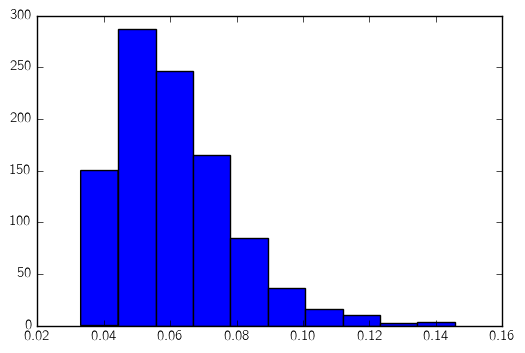

In [297]:
plt.hist(np.exp(log_weight))

In [326]:
norm = np.sum(weights)
mu = np.sum(params * weights[:, None], axis=0) / norm
np.sqrt(2 * np.sum((params - mu)**2 * weights[:, None], axis=0) / norm), tau

(array([ 0.59713739,  1.46000635,  2.27346253,  5.98294175,  5.39294517]),
 array([ 0.87059977,  1.75613841,  2.2552407 ,  5.79406228,  5.74521964]))

In [318]:
tau = np.sqrt(2*np.var(params, axis=0))
eps = np.percentile(rho, 50)
weights = np.exp(log_weight - np.logaddexp.reduce(log_weight))

In [319]:
new_samples_2 = [pmc_sample_one(eps, params, weights, tau) for _ in tqdm.tqdm(range(N), total=N)]

In [320]:
rho = np.array([s[1] for s in new_samples_2])
m = np.isfinite(rho)
rho = rho[m]
params = np.array([s[0] for s in new_samples_2])[m]
log_weights = np.array([s[3] for s in new_samples_2])[m]

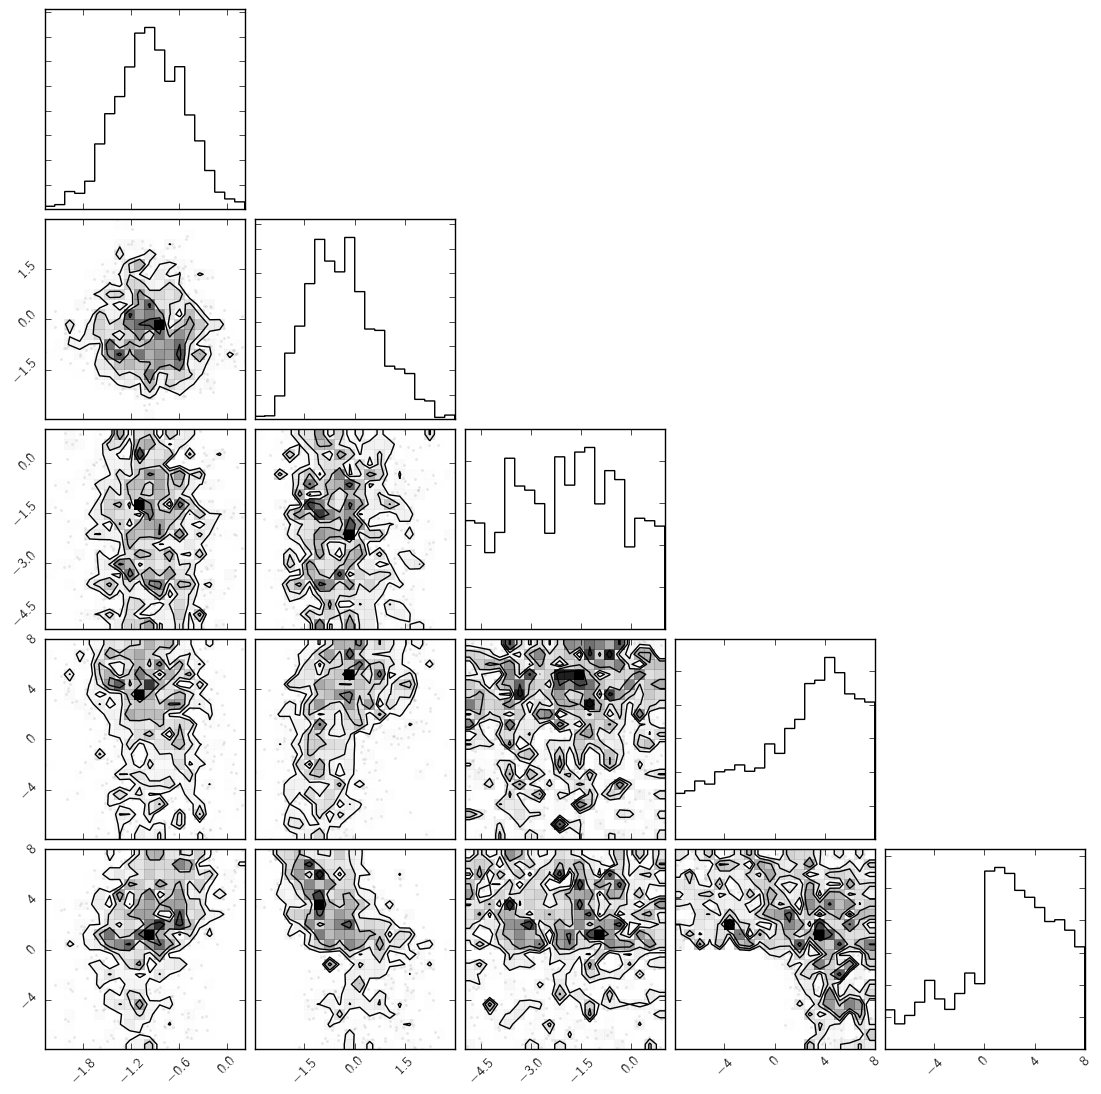

In [321]:
corner.corner(params, weights=np.exp(log_weight));

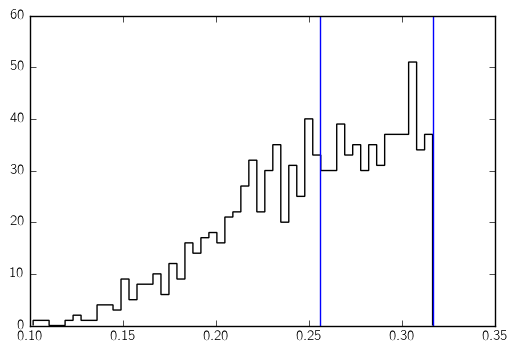

In [322]:
plt.hist(rho, 50, histtype="step", color="k")
plt.gca().axvline(eps)
plt.gca().axvline(np.percentile(rho, 50));

In [373]:
def scale_random(pars, u):
    n = len(pars)
    logu = np.log(u)
    norm = 0.0  #-np.inf
    value = 0.0  #-np.inf
    for i in range(n):
        norm = np.logaddexp(norm, pars[i])
    for i in range(n):
        value = np.logaddexp(value, pars[i])
        if (value - norm > logu):
            return i
    return n-1

(array([   47.,     0.,  4934.,    19.]),
 array([ 1. ,  1.5,  2. ,  2.5,  3. ]),
 <a list of 4 Patch objects>)

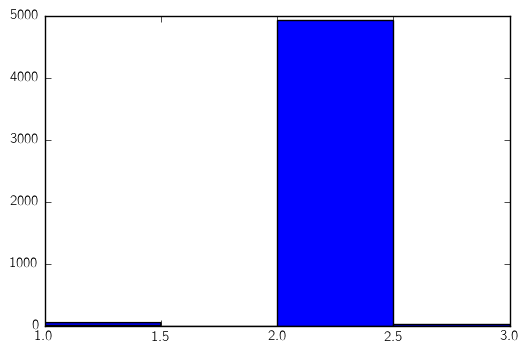

In [379]:
x = [scale_random([0.0, 6.54973016, 11.39524634, 5.84320176], np.random.rand()) for _ in range(5000)]
plt.hist(x, 4)

In [377]:
x

[2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,


In [392]:
import h5py
with h5py.File("blah.h5", "w") as f:
    f.create_dataset("blah", data=states)